In [99]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [100]:
%load_ext autoreload
%autoreload 2
#import CCPA_lib as cp
import sorf_lib as sf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [174]:
sns.set_context('poster')
sns.set_style('white')


![](http://oregonstate.edu/instruct/bb450/fall14/stryer7/2/table_02_02.jpg)

https://www.uniprot.org/uniprot/Q7V735

http://tigrfams.jcvi.org/cgi-bin/HmmReportPage.cgi?acc=TIGR03798

https://www.ebi.ac.uk/training/online/course/interpro-functional-and-structural-analysis-protei/sequence-searching/searching-interpro-batc

http://www.ebi.ac.uk/interpro/sequencesearch/iprscan5-S20190707-131508-0462-76111813-p1m

https://www.ebi.ac.uk/Tools/services/rest/iprscan5/result/iprscan5-S20190707-131508-0462-76111813-p1m/json

In [102]:
dpath = 'orffinder_tmp'
summary_suffix = '.sorf.summary.csv.gz'
sorf_result_suffix = '.sorf.feather.gz'

In [103]:
sum_dfs = [pd.read_csv(os.path.join(dpath, i))
           for i in os.listdir(dpath)
           if i.endswith(summary_suffix)
          ]
sum_df = pd.concat(sum_dfs)
sum_df.reset_index(inplace=True, drop=True)
sum_df.drop(columns=['Unnamed: 0', 'index'], inplace=True)

In [104]:
def get_metadata_map(column_name):
    metadf1 = pd.read_excel(os.path.join('data', 'metadata_pro_biller.xlsx'), sheet_name='Sheet1')
    metadf2 = pd.read_excel(os.path.join('data', 'metadata_pro_biller.xlsx'), sheet_name='Sheet2')
    clades_df1 = metadf1.loc[:, ['Name', column_name]]
    clades_df2 = metadf2.loc[:, ['Strain', column_name]]
    clade_map = dict(zip(clades_df1.Name,clades_df1[column_name]))
    clade_map.update(dict(zip(clades_df2.Strain,clades_df2[column_name])))
    return clade_map

In [259]:
col_bp = 'Assembly size (bp)'
col_bp2 = 'Assembly size (mbp)'

sum_df['Clade'] = sum_df.genome.map(get_metadata_map('Clade'))
sum_df[col_bp] = sum_df.genome.map(get_metadata_map(col_bp))
sum_df[col_bp2] = sum_df[col_bp] / 1e6

In [163]:
omap = {'standalone' : 'Standalone', 
        'out_frame' : 'Out of Frame', 
        'antisense' : 'Antisense', 
        'in_frame' :'In Frame', 
        'known' : 'Annotated'}
sum_df = sum_df.loc[sum_df.otype != 'overlap']
sum_df.otype = sum_df.otype.map(omap)
sum_df.otype.unique()

C:\Users\wosnat\Anaconda3\lib\site-packages\pandas\core\generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


array(['Antisense', 'In Frame', 'Annotated', 'Out of Frame', 'Standalone'],
      dtype=object)

In [164]:
oorder = ['Standalone', 'Antisense', 'In Frame', 'Out of Frame', 'Annotated', ]

In [165]:
opalette = sns.color_palette("rainbow", 6).as_hex()
del opalette[4]
opalette

['#386df9', '#12c8e6', '#5af8c8', '#a4f89f', '#ff6d38']

In [211]:
sns.color_palette("rainbow", 6)


[(0.21764705882352942, 0.42912060877260894, 0.9755119679804366),
 (0.0725490196078431, 0.7829276104921027, 0.9005867023006374),
 (0.3549019607843137, 0.9741386021045101, 0.7829276104921028),
 (0.6450980392156862, 0.9741386021045102, 0.622112816721474),
 (0.9274509803921569, 0.7829276104921029, 0.43467642176596505),
 (1.0, 0.42912060877260916, 0.2199463578396687)]

In [206]:
def plot_df(df, title, ylim=None):
    stacked_df = df.pivot_table(index=['Clade', 'genome'], columns=['otype'], values=['count'])
    stacked_df.columns = stacked_df.columns.droplevel()
    stacked_df.plot(kind='bar', stacked=True)
    plt.legend(bbox_to_anchor=(2,1))
    if ylim is not None:
        plt.ylim(ylim)
    plt.title(title)
    return stacked_df

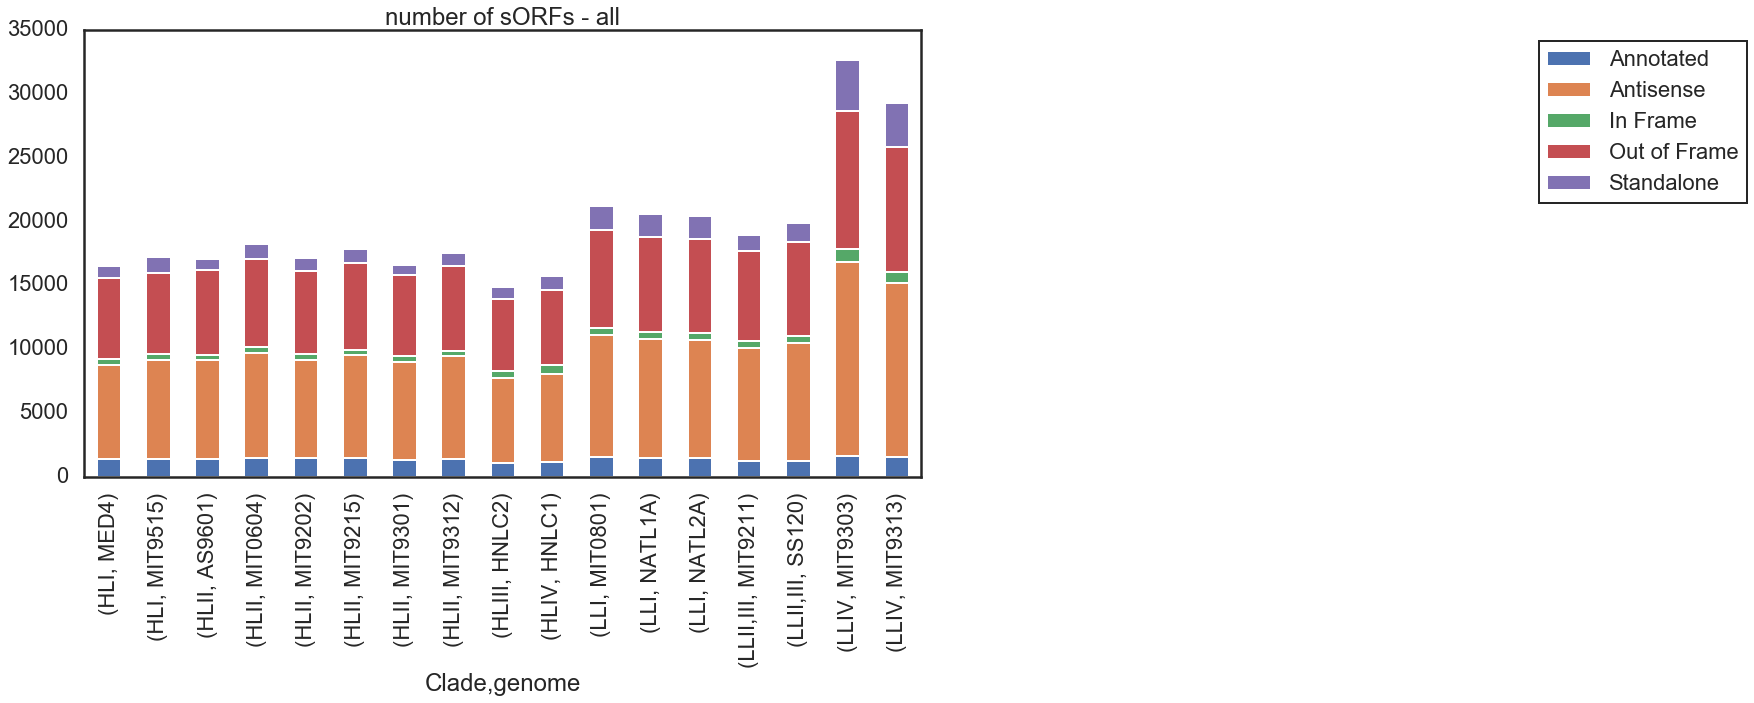

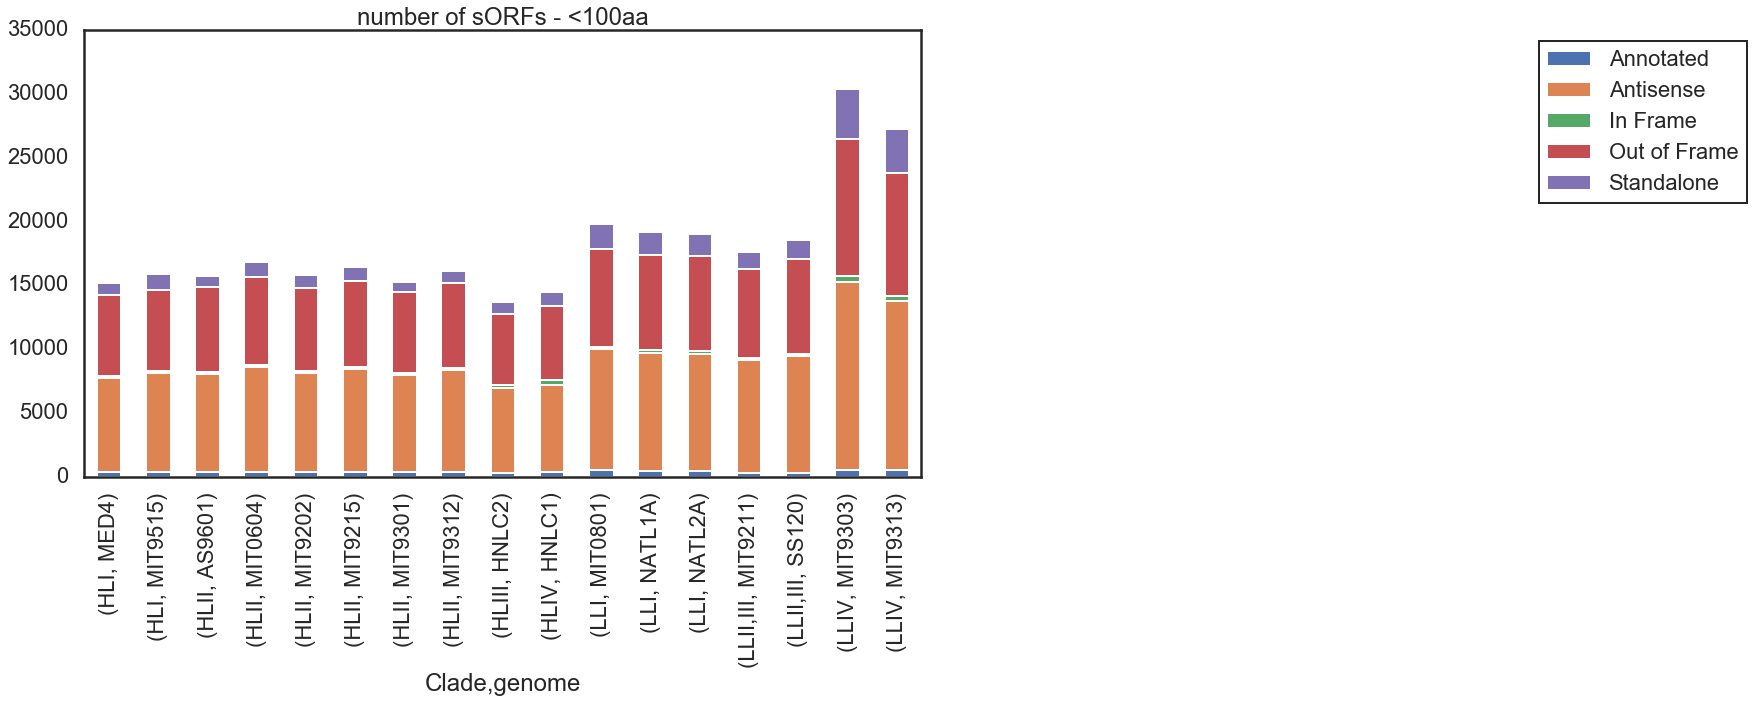

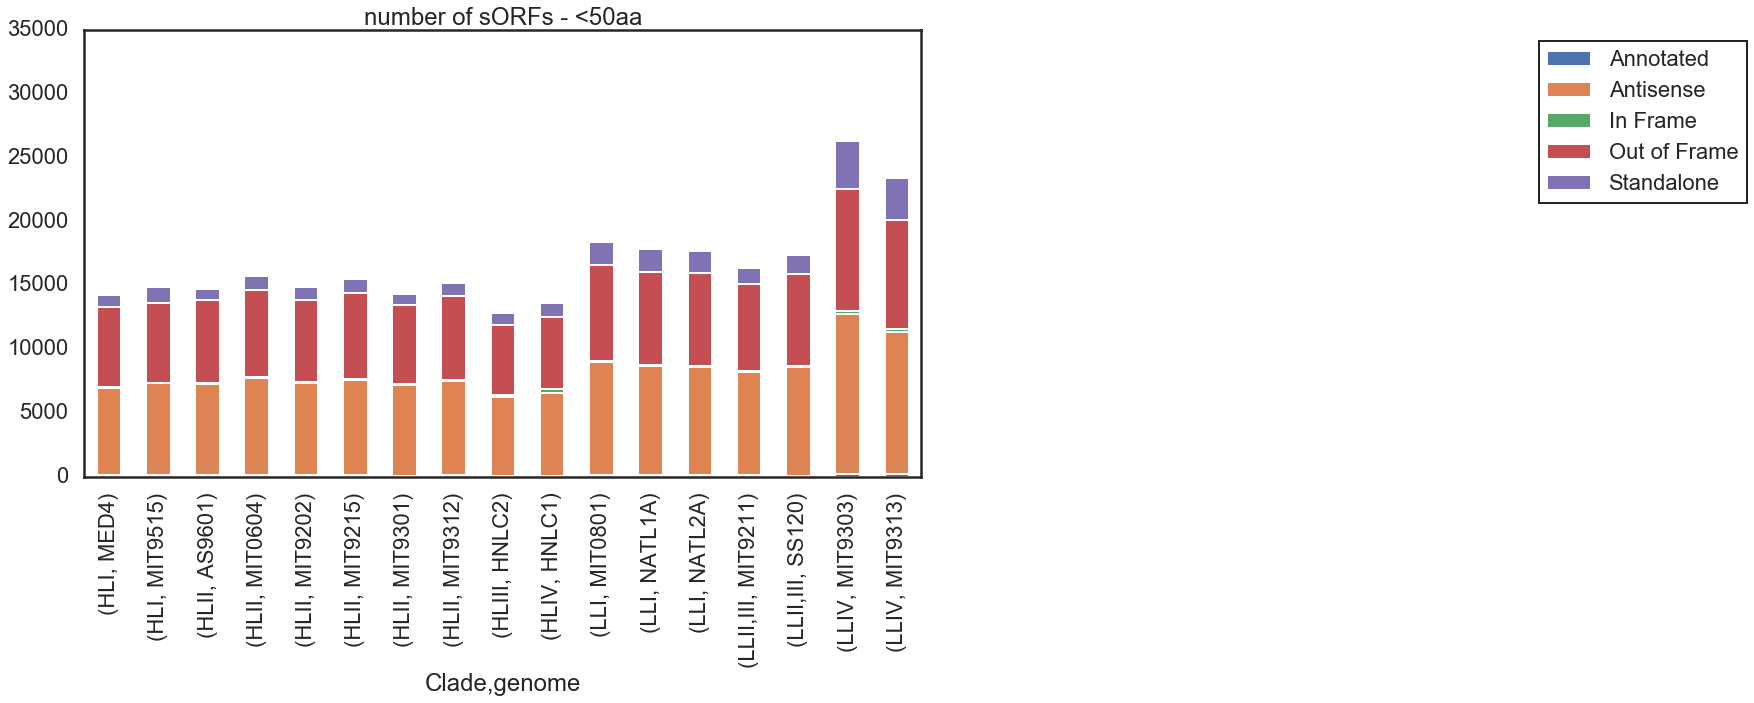

In [210]:
for s in sum_df.subset.unique():
        stacked_df = plot_df(sum_df.loc[(sum_df.subset == s) ], f'number of sORFs - {s}', ylim=(0,35000))
        if s == 'all':
            stacked_df.to_csv('f.csv')

(array([1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8]),
 <a list of 8 Text xticklabel objects>)

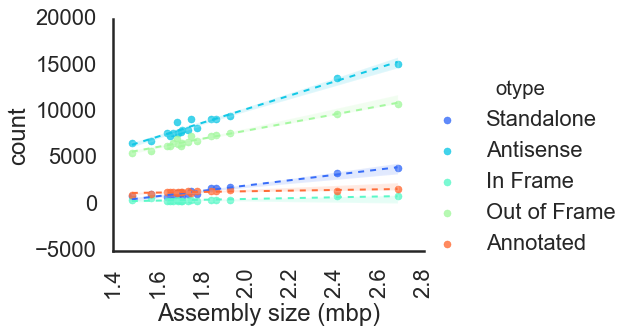

In [260]:
sns.lmplot(data=sum_df.loc[sum_df.subset == 'all'], 
           x=col_bp2, hue='otype', y='count', #row='subset', 
           hue_order=oorder, palette=opalette,
           aspect=1.4, #markers=True,
           #x_ci='sd',
           scatter=True,
           scatter_kws=dict(s=50),
           line_kws=dict(linewidth=2, linestyle='dashed'),
           truncate=True
          )
#plt.yscale('log')
plt.xticks(rotation='90') 

In [215]:
(3e6 - 1.2e6)/3

600000.0

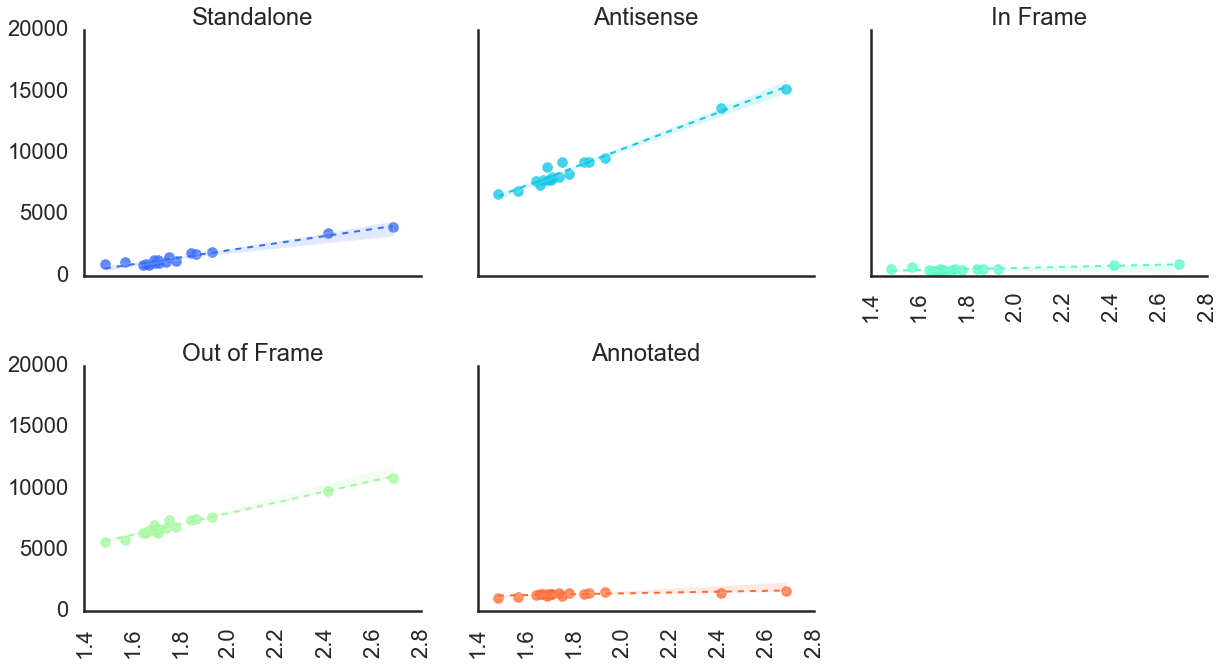

In [264]:

g = sns.lmplot(data=sum_df.loc[sum_df.subset == 'all'], 
           x=col_bp2, col='otype', y='count', #row='subset', 
               col_order=oorder, palette=opalette,
               hue='otype', hue_order=oorder,
           aspect=1.2, #markers=True,
           height=5, col_wrap=3,
           #x_ci='sd',
           scatter=True,
           scatter_kws=dict(s=100),
           line_kws=dict(linewidth=2, linestyle='dashed'
                        ),
           truncate=True
          )
g.set_titles("{col_name}")
#plt.yscale('log')
#g.set_major_locator(ticker.MultipleLocator(600000))
#g.set_major_formatter(ticker.ScalarFormatter())
#.set(xticks=range(1200000, 3000000, 600000))
#g.axes.set(xlim=(0,3000000))
#plt.ylim((0,20000))
g.set_xticklabels(rotation=90).set(ylim=(0, 20000), 
                                   ylabel='', xlabel='')
#.set_axis_labels("Total bill (US Dollars)", "Tip")
           #xticks=[10, 30, 50], yticks=[2, 6, 10])
      #.fig.subplots_adjust(wspace=.02))

In [22]:
otype_order = [
    'known',
    'standalone',
    'as',
    'as_internal',
    'as_internal_out_frame',
    'as_out_frame',
    'internal_out_frame',
    'downstream_out_frame',
    'downstream_upstream_out_frame',
    'upstream_out_frame',
    'internal',
    'downstream',
    'upstream',
    'overlap_many',
]
otype_palette = ['blue', 'yellow'] + sns.color_palette("Reds", 4).as_hex() + \
    sns.color_palette("Greens", 4).as_hex() + \
    sns.color_palette("Purples", 4).as_hex() 
    

In [19]:
sum_df.head()

,otype,count,subset,genome,Clade,Assembly size (bp)
0,antisense,7753,all,AS9601,HLII,1669886
1,in_frame,406,all,AS9601,HLII,1669886
2,known,1410,all,AS9601,HLII,1669886
3,out_frame,6596,all,AS9601,HLII,1669886
4,overlap,542,all,AS9601,HLII,1669886


In [87]:
df.head()

,orfid,contig,left,right,start,stop,strand,aaseq,len_nn,len_aa,...,is_inside,is_out_of_frame,is_same_strand,is_upstream,otype,overlap_count,overlap_gene_type,overlap_location,overlap_strand,overlap_type
0,ORF1_BX548175.1:78:176,BX548175.1,78,176,78,176,+,MNENDLPLHFLLACEILGDLFSVLVLVVTLIQ,99,32,...,0.0,1.0,1.0,1.0,out_frame,1,peg,MIT9313_174_1340,+,upstream_out_frame
1,ORF2_BX548175.1:453:590,BX548175.1,453,590,453,590,+,MRLVNRLNSKVQAGVIRCVGCLLMIFLNYLLLKVVRLSRLMRGLF,138,45,...,1.0,1.0,1.0,0.0,out_frame,1,peg,MIT9313_174_1340,+,internal_out_frame
2,ORF3_BX548175.1:669:722,BX548175.1,669,722,669,722,+,MVKPWKQRQLMVTALPF,54,17,...,1.0,1.0,1.0,0.0,out_frame,1,peg,MIT9313_174_1340,+,internal_out_frame
3,ORF4_BX548175.1:972:1025,BX548175.1,972,1025,972,1025,+,MVLLGVSMLIGVLLLQL,54,17,...,1.0,1.0,1.0,0.0,out_frame,1,peg,MIT9313_174_1340,+,internal_out_frame
4,ORF5_BX548175.1:1167:1205,BX548175.1,1167,1205,1167,1205,+,MLFRLLLMFVMY,39,12,...,1.0,1.0,1.0,0.0,out_frame,1,peg,MIT9313_174_1340,+,internal_out_frame


In [97]:
d = df.groupby(['overlap_location', 'otype', 'overlap_type']).agg({'len_aa' : 'median', 'orfid':'count' }).reset_index()
d
#d.sort_values('orfid', ascending=False)

,overlap_location,otype,overlap_type,len_aa,orfid
0,,standalone,standalone,18.0,3469
1,MIT9313_1000098_999979,antisense,as_out_frame,25.0,1
2,MIT9313_1000098_999979,in_frame,upstream,47.0,1
3,"MIT9313_1000098_999979,MIT9313_1000145_1000285",overlap,overlap_many,16.0,1
4,MIT9313_1000145_1000285,antisense,as_internal_out_frame,13.0,1
5,MIT9313_1000145_1000285,in_frame,internal,42.0,1
6,"MIT9313_1000145_1000285,MIT9313_1000290_1000487",overlap,overlap_many,119.0,1
7,MIT9313_1000290_1000487,antisense,as_out_frame,56.0,1
8,MIT9313_1000290_1000487,out_frame,downstream_out_frame,19.0,1
9,MIT9313_1000290_1000487,out_frame,internal_out_frame,17.0,1


In [98]:
1000000 - 999800

200

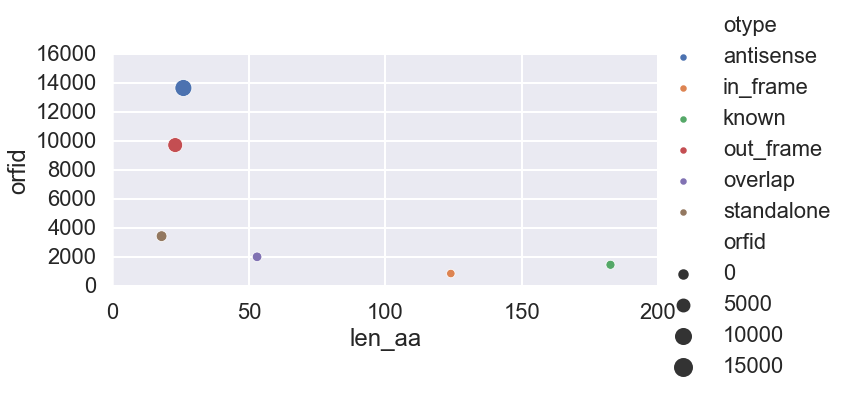

In [89]:
sns.relplot(data=d, hue='otype', x='len_aa', y='orfid', size='orfid',
            #s=100,
            #kind='line', 
            aspect=2)
#plt.xscale('log')

In [20]:
def plot_sorf(genome = 'MED4'):
    df = pd.read_feather(os.path.join('orffinder_tmp', f'{genome}.sorf.feather.gz'))
    sns.catplot(data=df, y='overlap_type', kind='count', aspect=2, height=6,
           order=otype_order, palette=otype_palette)
    #plt.xticks(rotation=90) 
    plt.title(f'number of orfs - {genome}')

    sns.catplot(data=df, y='overlap_type', x='len_aa', aspect=2, height=6,
            kind='box',
           order=otype_order, palette=otype_palette)
    plt.xscale('log')
    plt.title(f'orfs lengths (aa) - {genome}')
    plt.show()
    

In [203]:
def plot_sorf(genome = 'MED4'):
    df = pd.read_feather(os.path.join('orffinder_tmp', f'{genome}.sorf.feather.gz'))
    df = df.loc[df.otype != 'overlap']
    df.otype = df.otype.map(omap)
    
    sns.catplot(data=df, y='otype', kind='count', aspect=2, height=6,
           order=oorder, palette=opalette
               )
    #plt.xticks(rotation=90) 
    plt.title(f'number of orfs - {genome}')

    sns.catplot(data=df, y='otype', x='len_aa', aspect=2, height=6,
            kind='box',
           order=oorder, palette=opalette
               )
    plt.xscale('log')
    plt.title(f'ORFs Lengths (Amino Acids) - {genome}')
    plt.show()
    

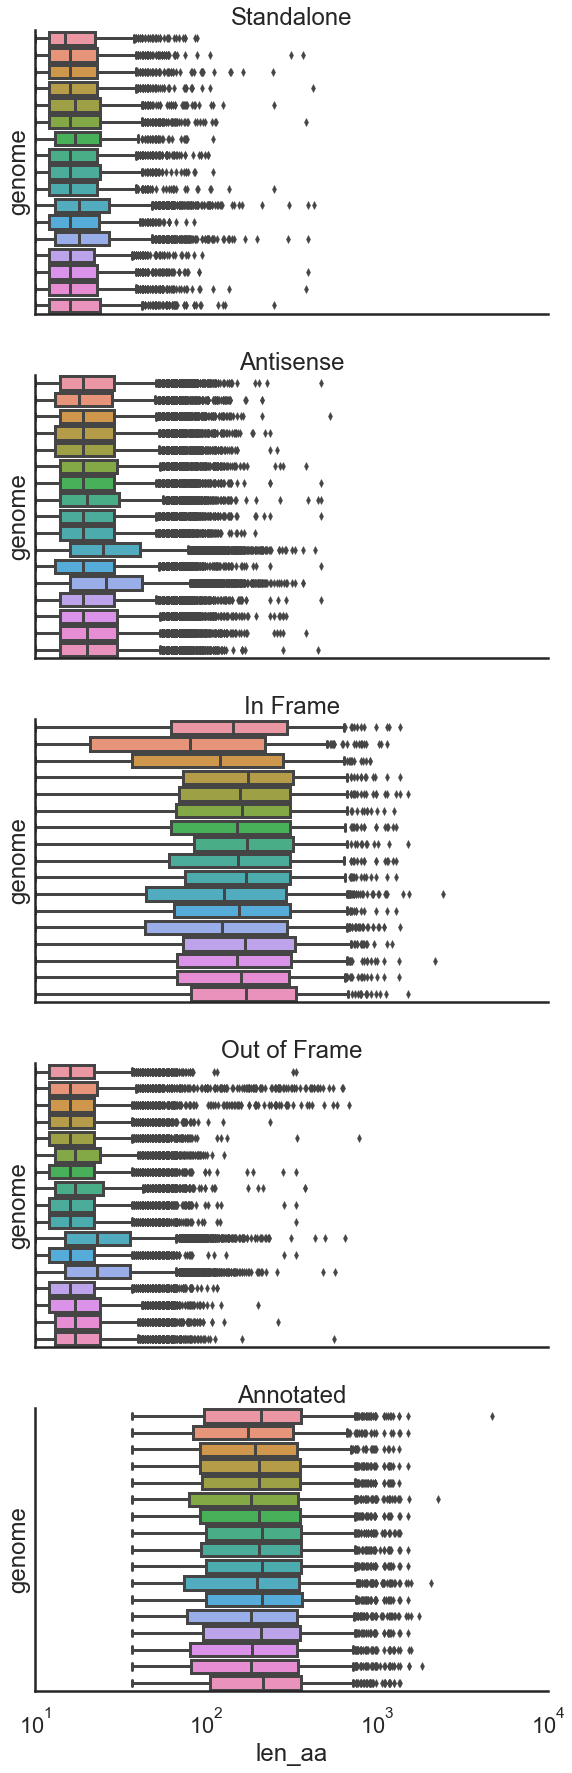

In [202]:
def _read(genome):
    df = pd.read_feather(os.path.join('orffinder_tmp', f'{genome}.sorf.feather.gz'))
    df['genome'] = genome
    return df
#df_list = [pd.read_feather(os.path.join('orffinder_tmp', f'{genome}.sorf.feather.gz'))
df_list = [_read(genome) for genome in sum_df.genome.unique()]
df = pd.concat(df_list)
df = df.loc[df.otype != 'overlap']
df.otype = df.otype.map(omap)



g = sns.catplot(data=df, row='otype', x='len_aa', aspect=2, height=5,
            kind='box', y='genome', #hue='otype', #hue_order=oorder,
           row_order=oorder, #palette=opalette
               )
g.set(yticks=[])
g.set_titles("{row_name}")

plt.xscale('log')
#plt.title(f'orfs lengths (aa) ')
plt.show()
    

In [183]:
df.head()

,orfid,contig,left,right,start,stop,strand,aaseq,len_nn,len_aa,...,is_inside,is_out_of_frame,is_same_strand,is_upstream,otype,overlap_count,overlap_gene_type,overlap_location,overlap_strand,overlap_type
0,ORF1_jcventer:AS9601:345:404,jcventer:AS9601,345,404,345,404,+,MELSKIVELSLYPQNFYQK,60,19,...,1.0,1.0,1.0,0.0,Out of Frame,1,peg,AS9601_168_1325,+,internal_out_frame
1,ORF2_jcventer:AS9601:516:560,jcventer:AS9601,516,560,516,560,+,MNILICHLLKAVLL,45,14,...,1.0,1.0,1.0,0.0,Out of Frame,1,peg,AS9601_168_1325,+,internal_out_frame
2,ORF3_jcventer:AS9601:618:677,jcventer:AS9601,618,677,618,677,+,MMIQSNYSQVSILLSNQII,60,19,...,1.0,1.0,1.0,0.0,Out of Frame,1,peg,AS9601_168_1325,+,internal_out_frame
3,ORF4_jcventer:AS9601:1098:1178,jcventer:AS9601,1098,1178,1098,1178,+,MLKILEMQMNQYLFLIQEKILILHLM,81,26,...,1.0,1.0,1.0,0.0,Out of Frame,1,peg,AS9601_168_1325,+,internal_out_frame
4,ORF5_jcventer:AS9601:1386:2033,jcventer:AS9601,1386,2033,1386,2033,+,MVLNYGNGENVWMHPPVHRILGWYSRPSNFDLKRNVWRLNQITQII...,648,215,...,1.0,0.0,1.0,0.0,In Frame,1,peg,AS9601_1327_2034,+,internal


C:\Users\wosnat\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


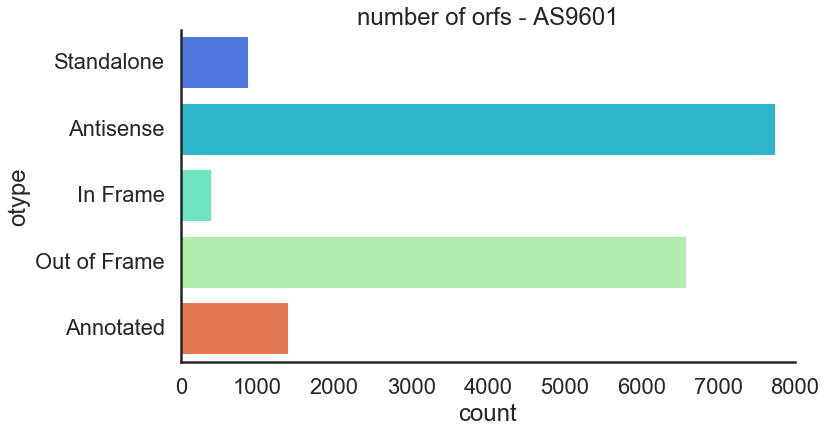

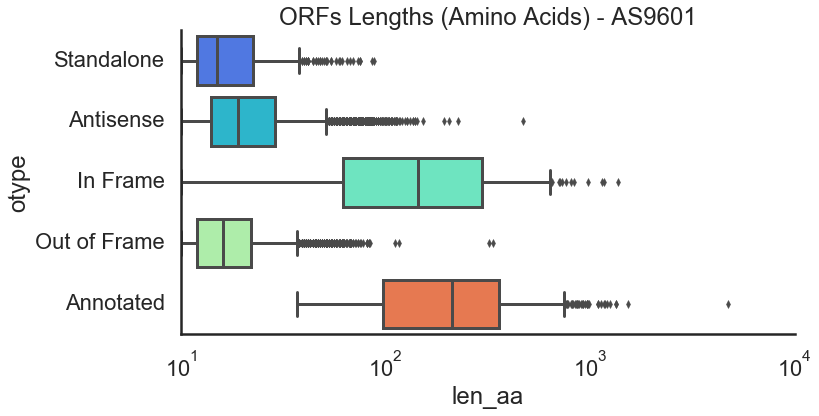

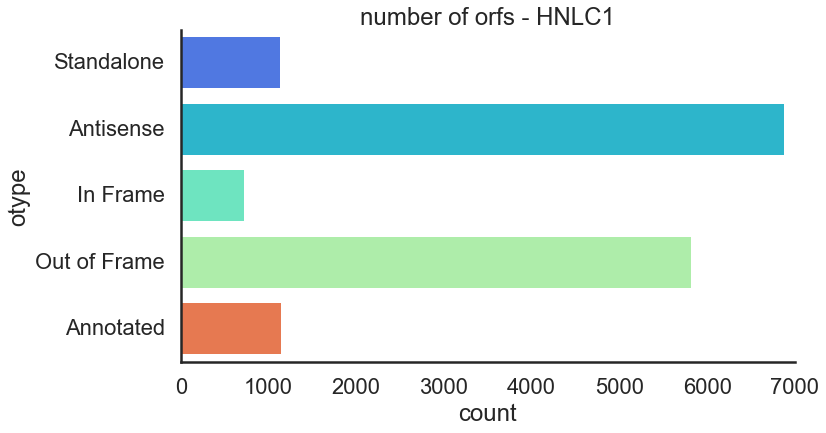

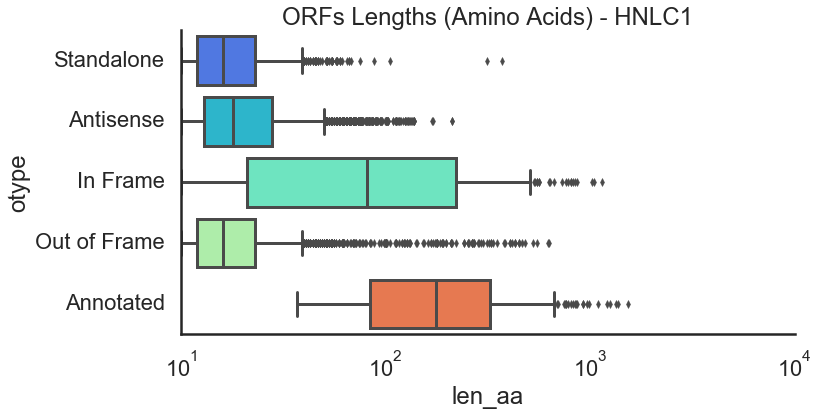

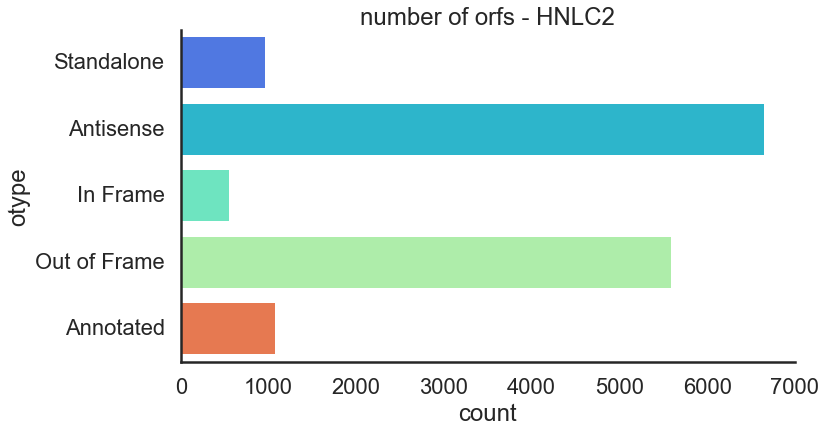

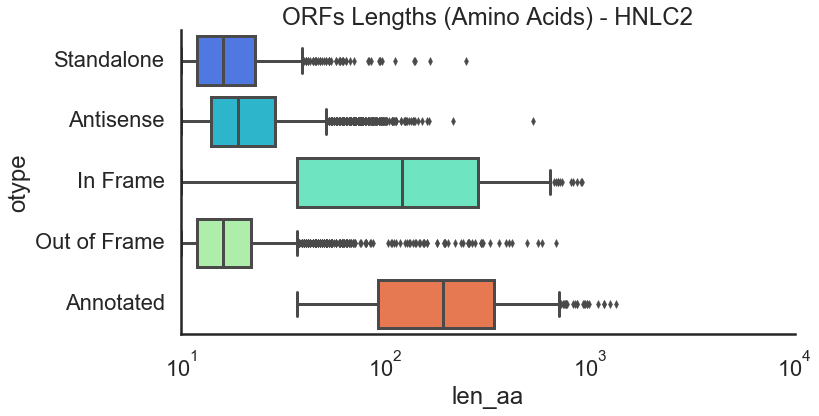

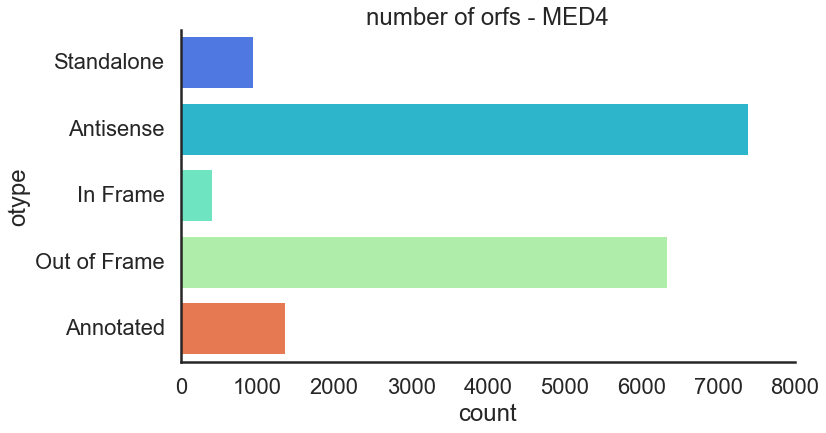

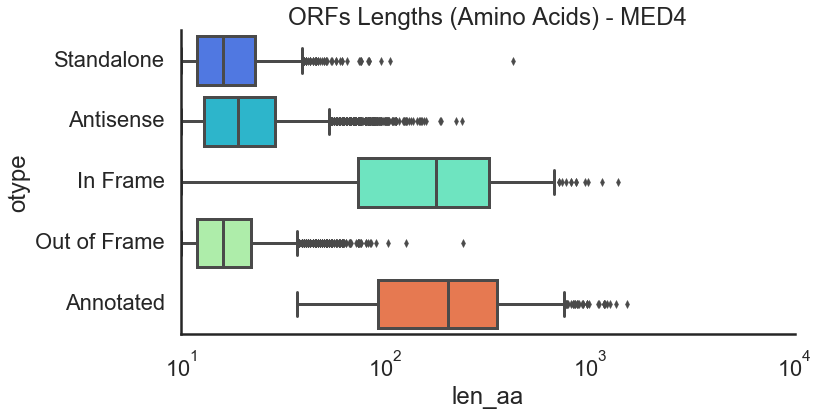

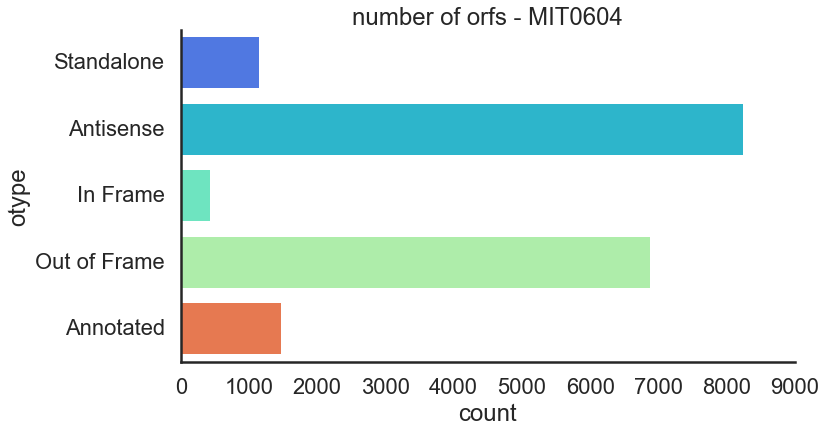

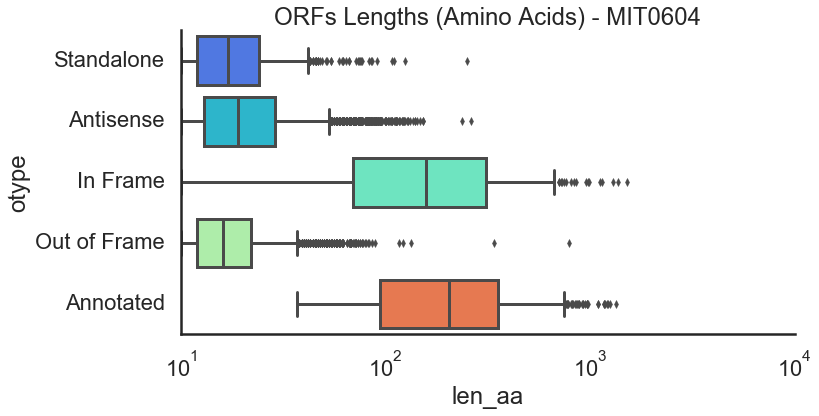

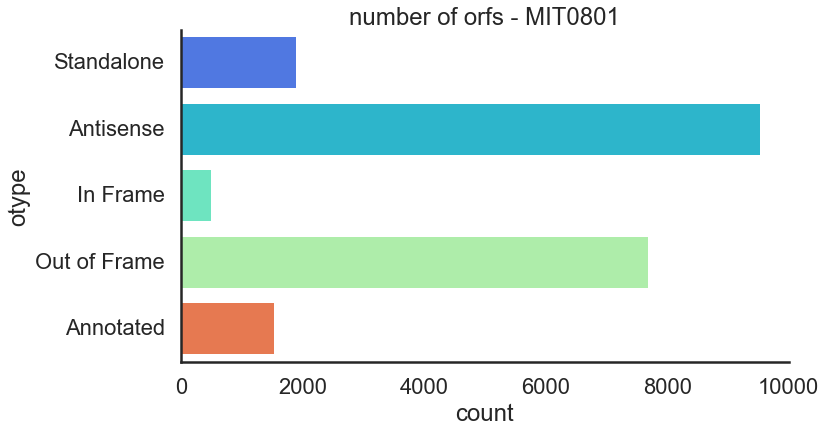

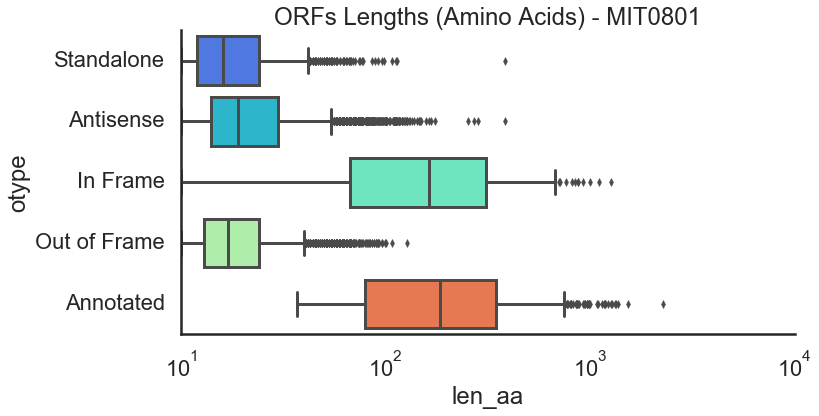

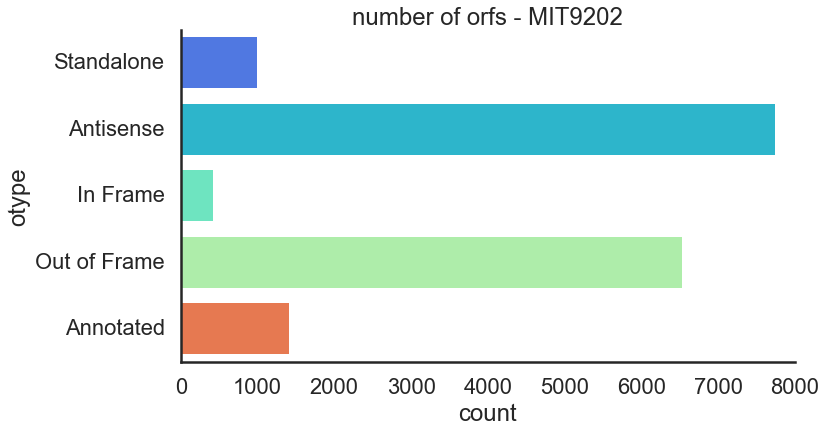

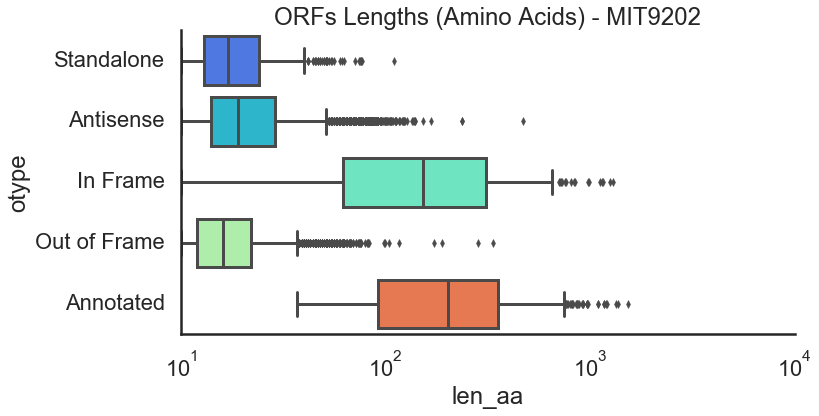

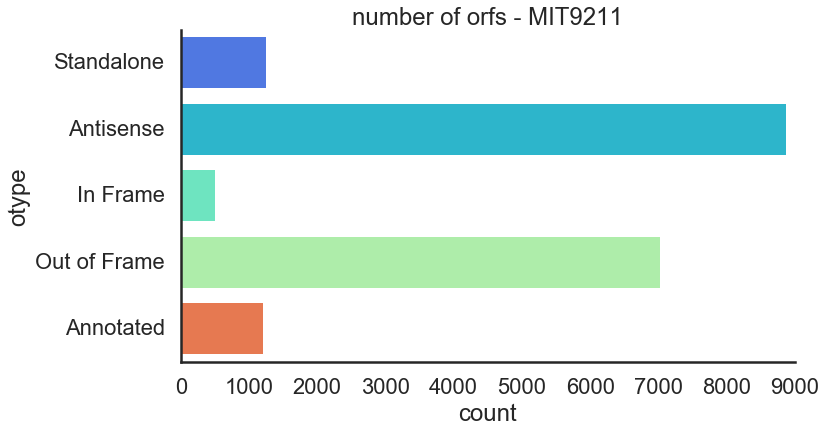

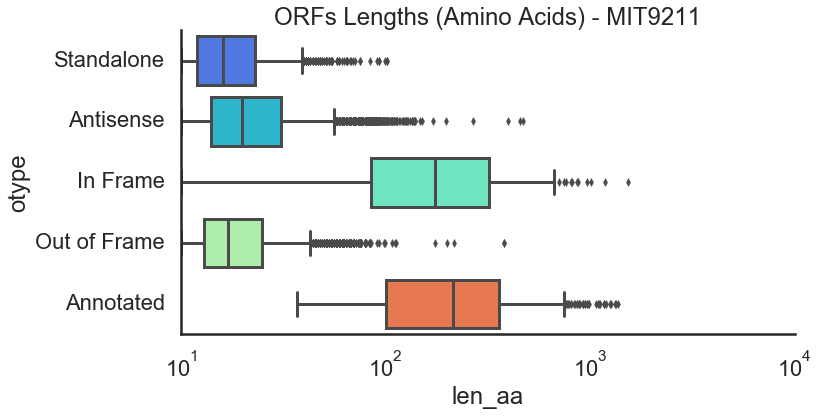

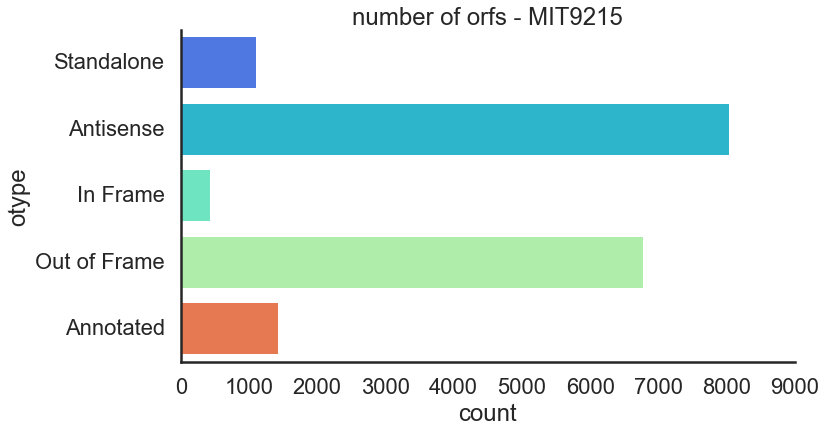

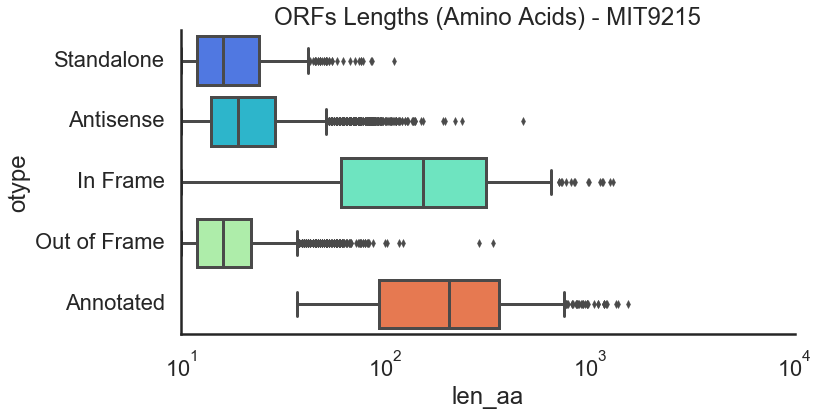

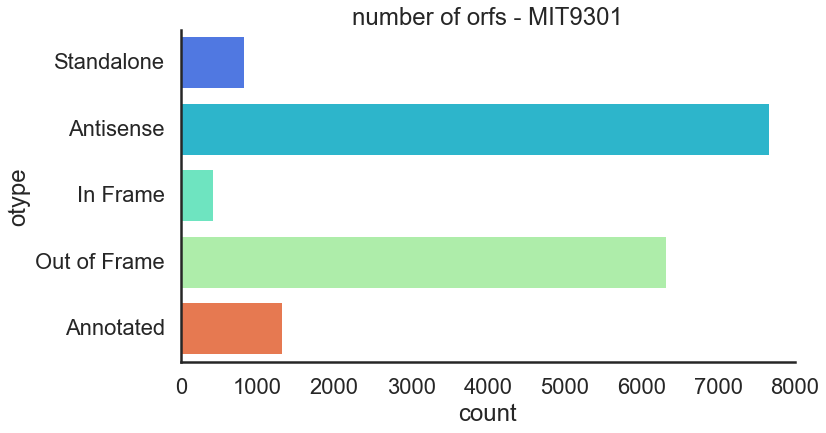

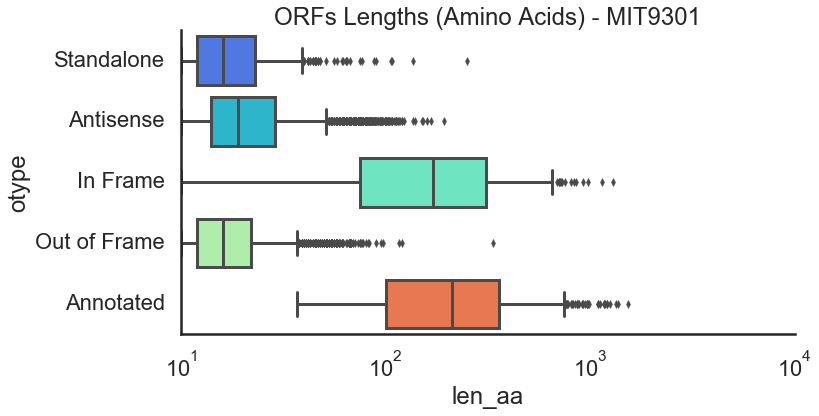

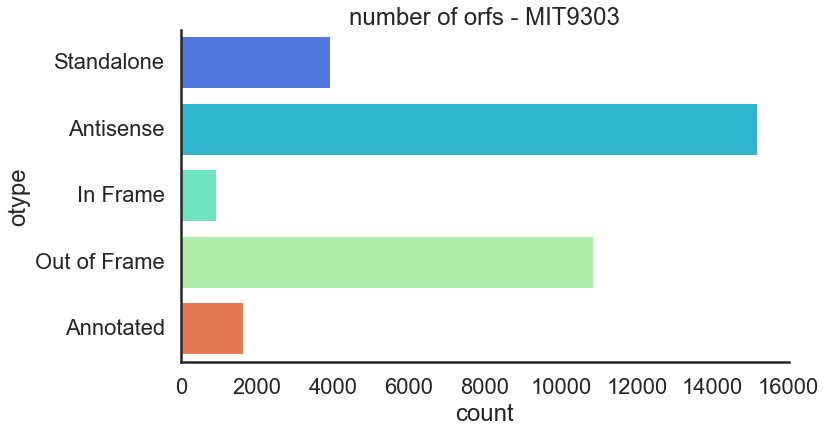

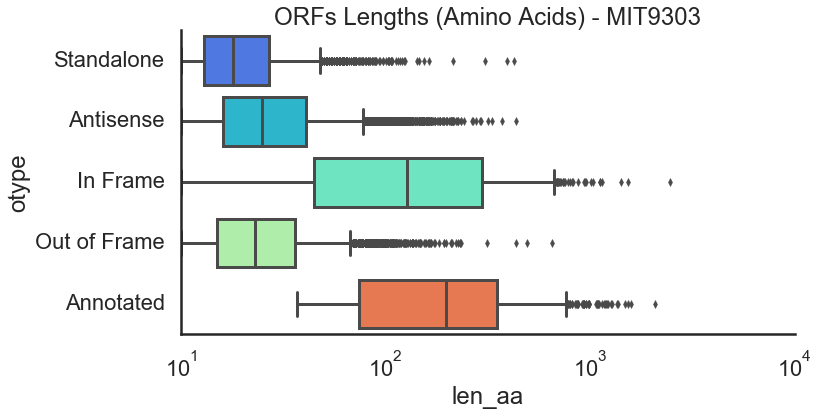

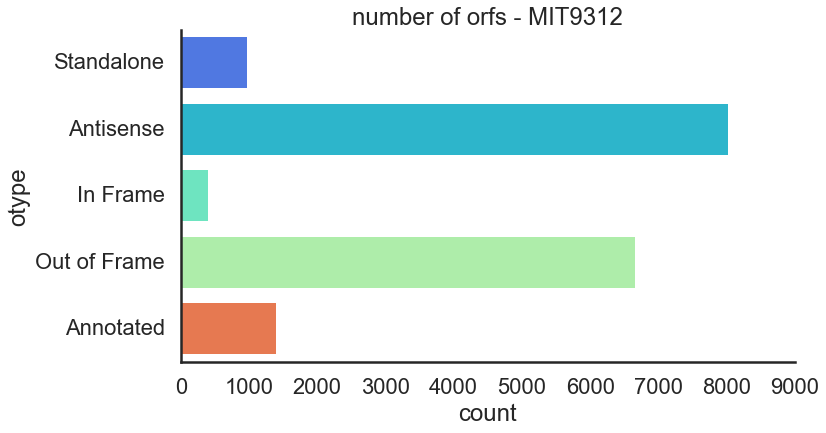

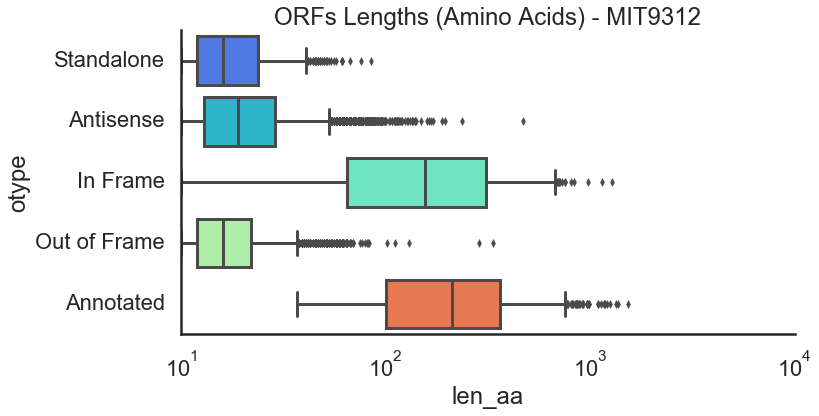

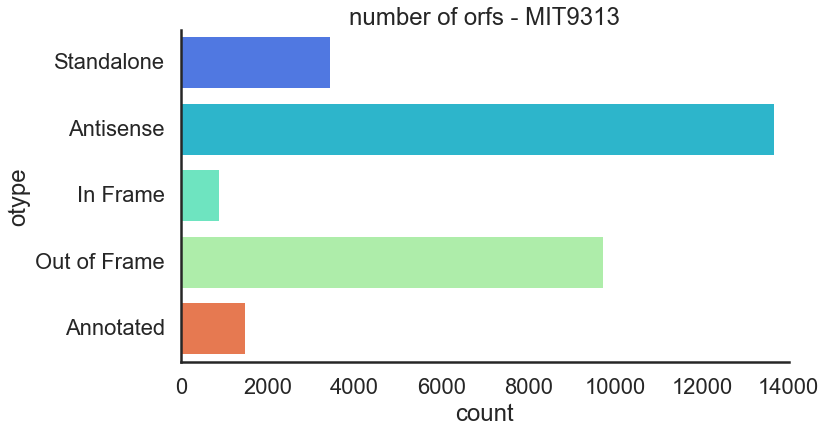

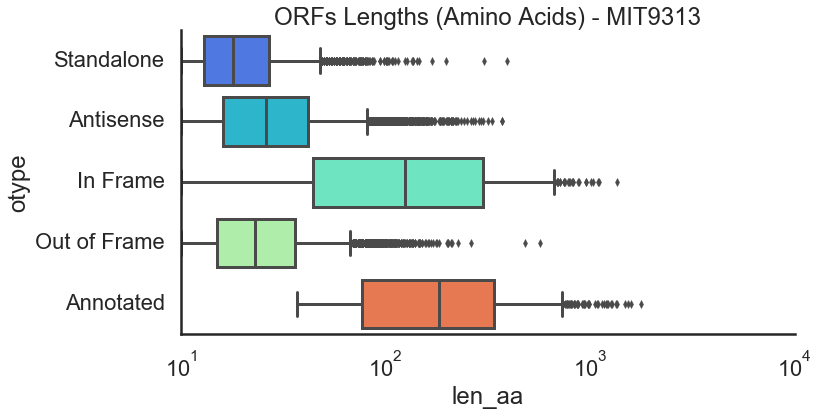

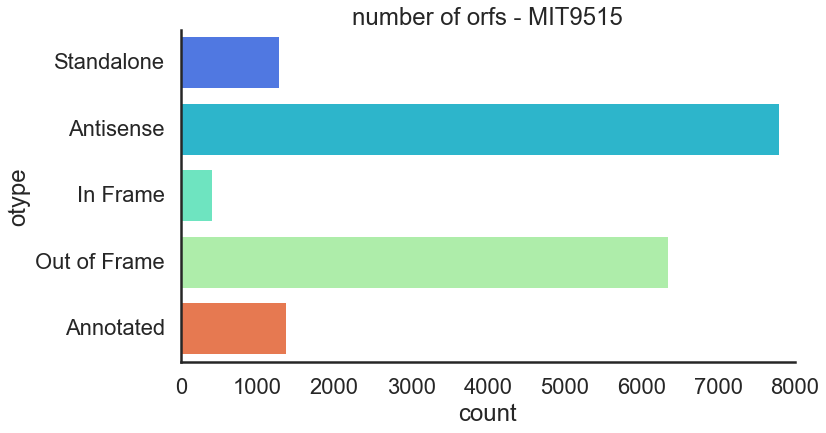

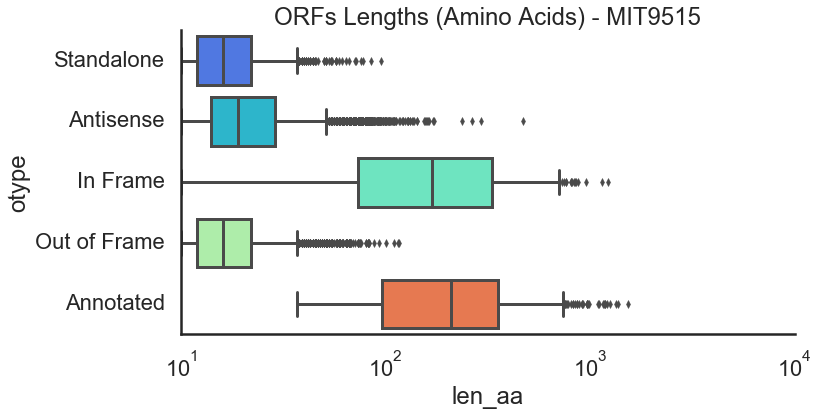

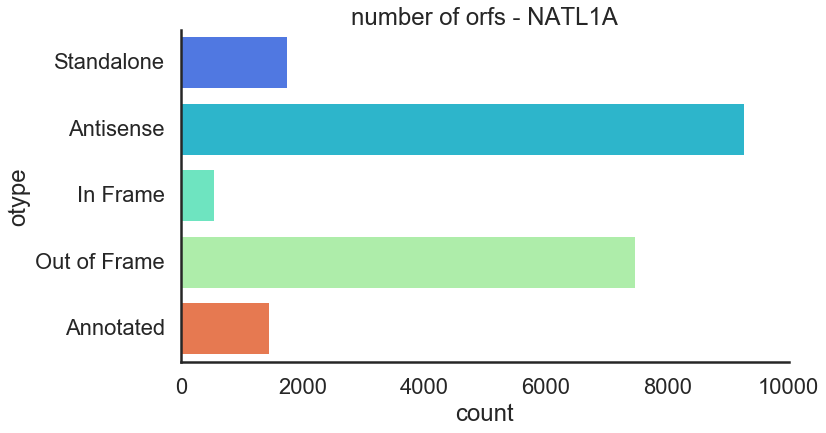

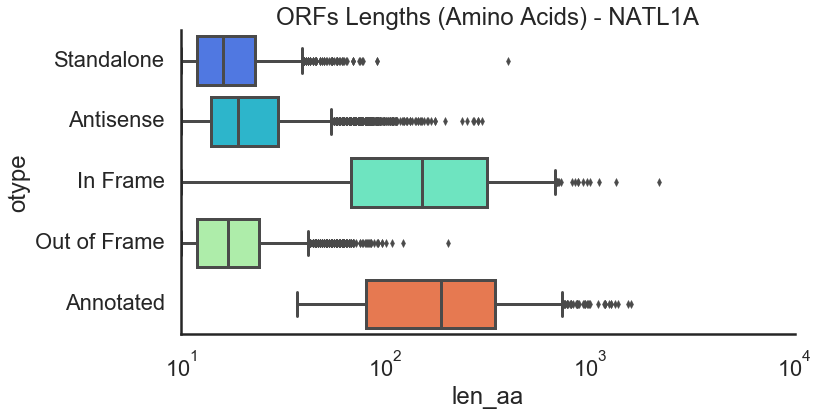

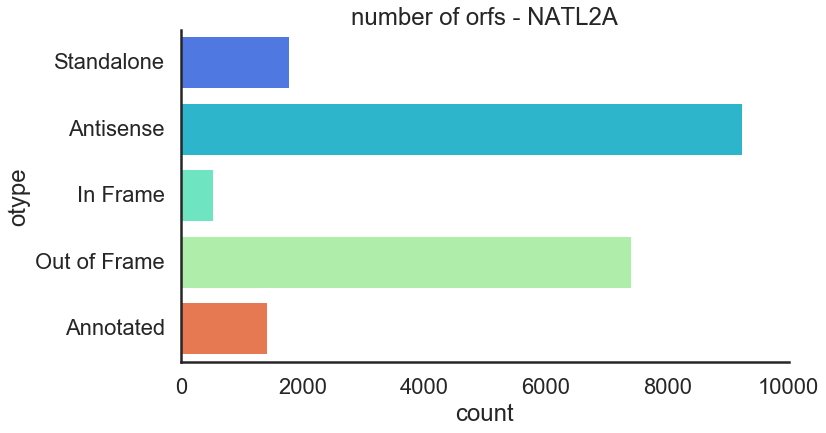

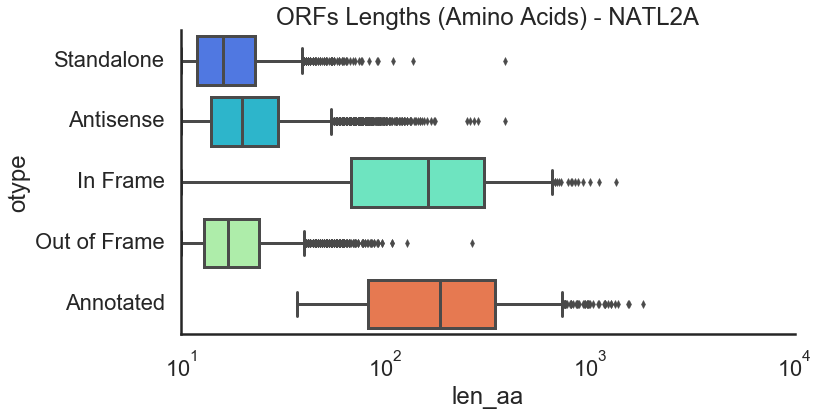

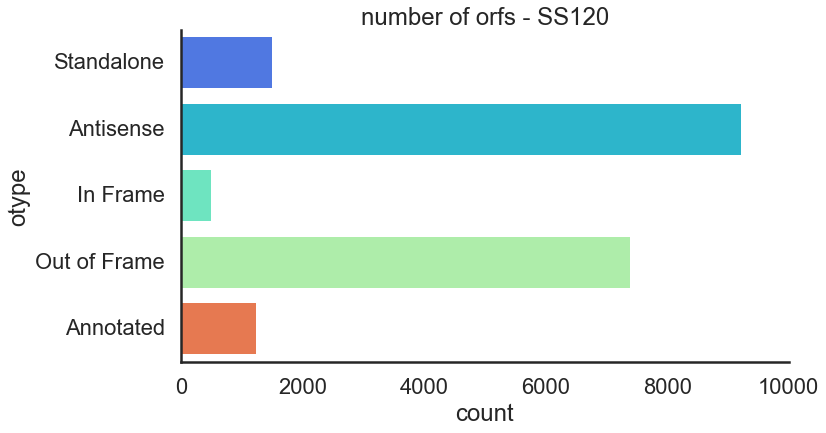

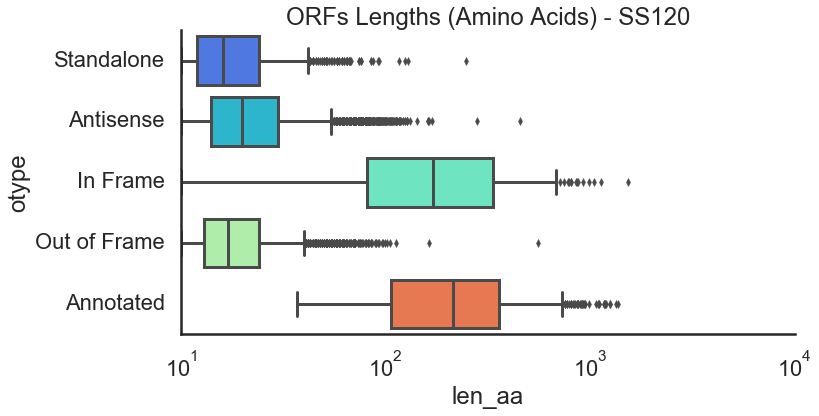

In [204]:
for i in sum_df.genome.unique():
    plot_sorf(i)